## Imports

In [88]:
import pandas as pd
import pickle
import spacy
import numpy as np
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib as plt
from matplotlib.pyplot import hist

## Loading Data

In [68]:
ekg_denoised = pd.read_pickle('/home/sanjaycollege15/PredictingDiagnoses/Data/ekg_denoised.pkl')
ekg_denoised = ekg_denoised.sample(frac=1)


In [69]:
ekg_denoised.head()

,ICD9_CODE,TEXT
5336,3,"a-v sequential pacing since previous tracing, ..."
831,0,baseline artifact. sinus tachycardia. since th...
2296,1,atrial fibrillation modest nonspecific low amp...
3807,2,sinus bradycardia. left axis deviation. consid...
628,0,sinus rhythm. left atrial abnormality. possibl...


## Padding

In [76]:
lengths = []
for i in ekg_denoised['TEXT']:
    lengths.append(len(i))
    
print(f"Average sentence length: {sum(lengths)/len(lengths)}")
print(f"Max sentence length: {max(lengths)}")
print(f"Min sentence length: {min(lengths)}")

Average sentence length: 201.8235924112607
Max sentence length: 832
Min sentence length: 0


## Spacy

#### Downloading and Loading Spacy Embeddings

In [1]:
#!python -m spacy download en_core_web_md

2021-11-17 00:38:48.868995: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-17 00:38:48.869188: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
     |████████████████████████████████| 45.7 MB 64 kB/s             
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [70]:
nlp = spacy.load('en_core_web_md')

#### Testing Spacy Embeddings

In [54]:
doc = nlp("sinus rhythm. compared to tracing 1 no diagnostic interim change. tracing 2")
print(doc.vector.shape)
doc.vector

(300,)


array([-5.00825867e-02,  2.34442070e-01, -1.47236139e-01,  1.79825034e-02,
       -3.41885015e-02, -5.65572195e-02,  9.41328239e-03, -4.99943532e-02,
        1.39321953e-01,  1.65153766e+00, -1.48617715e-01,  2.31521294e-01,
        8.35297704e-02,  1.76000714e-01,  1.16957293e-03, -5.54402284e-02,
        1.99811742e-01,  1.40888703e+00, -9.33964252e-02, -5.83115034e-02,
        3.43884304e-02,  3.40443780e-03, -2.34556273e-01, -1.05062291e-01,
       -8.92671105e-03,  1.92777123e-02, -8.44067335e-03,  1.91751588e-02,
        1.34894580e-01,  8.49958584e-02,  4.53957133e-02,  7.32796043e-02,
       -1.18446406e-02, -1.36181086e-01,  7.27292076e-02,  1.67326778e-01,
        1.02550071e-02,  8.56276304e-02,  6.58611134e-02, -6.31382093e-02,
        2.15512812e-02, -7.76198581e-02,  7.92574957e-02, -2.48679277e-02,
       -3.74911427e-02, -1.35982186e-01, -9.75067765e-02,  1.94221720e-01,
       -1.74879972e-02,  3.41023579e-02, -1.35499965e-02, -3.56617868e-02,
        9.32188630e-02, -

### Running Spacy on dataset

In [71]:
docs = list(nlp.pipe(ekg_denoised.TEXT))

#### Making embeddings for feed forward neural network (300x1)

In [10]:
spacy_embeddings = []
for i in docs:
    spacy_embeddings.append(i.vector)

In [11]:
ekg_denoised['spacy_embeddings'] = spacy_embeddings

In [ ]:
ekg_denoised.drop(columns='TEXT', inplace = True)

In [18]:
ekg_denoised.spacy_embeddings[4404].shape

(300,)

In [59]:
ekg_denoised.to_pickle('/home/sanjaycollege15/PredictingDiagnoses/Data/ekg_denoised_spacy.pkl')


In [1]:
# Averaging could be losing a lot of information

#### Making Embeddings for RNN (Samples x Num Words x 300)

In [ ]:
for doc in tokenizer.pipe(ekg_denoised[''])

In [57]:
doc_embeddings = []
for note in docs:
    word_embeddings = []
    for words in note:
        word_embeddings.append(np.array(words.vector))
    doc_embeddings.append(np.array(word_embeddings))
    
doc_embeddings_np = np.array(doc_embeddings)

<ipython-input-57-5a8c24199d5e>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  doc_embeddings_np = np.array(doc_embeddings)


In [86]:
lengths = []
for i in doc_embeddings_np:
    lengths.append(len(i))

(array([ 303., 2286., 2124., 1063.,  494.,  182.,   58.,   16.,    5.,
           5.]),
 array([  0. ,  13.9,  27.8,  41.7,  55.6,  69.5,  83.4,  97.3, 111.2,
        125.1, 139. ]),
 <BarContainer object of 10 artists>)

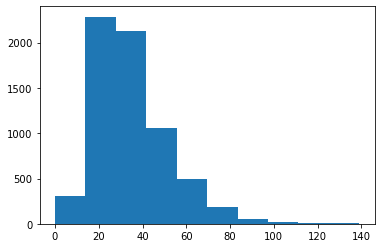

In [89]:
hist(lengths)

Need to pad to make sure all vectors are the same length (max length of vectors)

In [91]:
doc_embeddings_np[0]

array([[-0.59056 ,  0.015101, -0.38253 , ..., -0.47205 ,  0.18283 ,
        -0.095898],
       [-0.46994 ,  0.32694 , -0.55999 , ...,  0.35904 ,  0.1866  ,
        -0.43598 ],
       [ 0.4809  ,  0.47481 , -0.25696 , ...,  0.2593  , -0.16764 ,
        -0.16269 ],
       ...,
       [-0.14121 ,  0.034641, -0.443   , ..., -0.29866 ,  0.013515,
         0.025409],
       [-0.219   ,  0.30927 , -0.11087 , ..., -0.33372 , -0.055948,
        -0.15883 ],
       [ 0.24095 ,  0.42528 , -0.175   , ...,  0.29562 , -0.076305,
         0.091093]], dtype=float32)

In [ ]:
numpy.save('/home/sanjaycollege15/PredictingDiagnoses/Data/ekg_denoised_spacy_RNN.pkl',
           doc_embeddings_np,
           allow_pickle=True)

numpy.save
